In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torchvision.transforms import ToTensor
from torch.optim import Adam

from context import *
from LocalLearning import Attacks
from LocalLearning import KHModel, FKHL3, SHLP
from LocalLearning import Data
from LocalLearning import Trainers
from LocalLearning.Regularizers import LpReg, JFReg, SpecReg
from LocalLearning.Statistics import cov_spectrum

from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt
plt.style.use(['seaborn-paper', "../stlsheets/PRLDoubleCol.mplstyle"])

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
# HYPERPARAMETERS
# train flip switch 
TRAIN = True

BATCH_SIZE = 1000
NUMBER_OF_EPOCHS = 1000
LEARNING_RATE = 1e-3

model_path = Path("../data/repro/models")
figure_path = Path("../data/repro/figures")

# khmodel path variables
khlayer_name = Path("fkhl3_cifar10_repro_pruned.pty")
khmodel_name = Path("khmodel_cifar10_repro_pruned.pty")
khmodel_log_name = Path("khmodel_cifar10_repro_log.json")

# shlp initialisation
shlp_init_name = Path("shlp_init.pty")

# shlp without regularization path variables
shlp_name = Path("shlp_cifar10.pty")
shlp_log_name = Path("shlp_cifar10_log.json")

# shlp with L2 reg path variables
shlp_l2_name = Path("shlp_l2.pty")
shlp_l2_log_name = Path("shlp_l2_log.json")

# shlp with Jacobian regularization path variables
shlp_jreg_name = Path("shlp_jreg.pty")
shlp_jreg_log_name = Path("shlp_jreg_log.json")

# shlp with Spectral Regularization path variables
shlp_specreg_name = Path("shlp_specreg.pty")
shlp_specreg_log_name = Path("shlp_specreg_log.json")

# shlp with Spectral Regularization and Parameters similar to Krotov and Hopfield Exponent on CIFAR10
shlp_specreg_kh_name = Path("shlp_specreg_kh.pty")
shlp_specreg_kh_log_name = Path("shlp_specreg_kh_log.json")

In [4]:
cmap = {
    "kh": '#1b9e77', #"#762a83",
    "hybrid": '#d95f02', #"#f8a953",
    "bp": '#7570b3', #"#1b7837",#"#106151",
}

#1b9e77
#d95f02
#7570b3

In [5]:
# load the local learning model
state_dict = torch.load(model_path / khlayer_name)
khlayer = FKHL3(state_dict)

khmodel = KHModel(khlayer, no_classes=10)
khmodel.to(device)

In [6]:
# define training and test datasets for training
cifar10Train= Data.LpUnitCIFAR10(
    root="../data/CIFAR10",
    train=True,
    transform=ToTensor(),
    p=khlayer.pSet["p"],
)

TrainLoader = Data.DeviceDataLoader(
    cifar10Train,# define batch window in the global index coordinates
    device=device,
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=True,
)

cifar10Test = Data.LpUnitCIFAR10(
    root="../data/CIFAR10",
    train=False,
    transform=ToTensor(),
    p=khlayer.pSet["p"],
)

TestLoader = Data.DeviceDataLoader(
    cifar10Test,
    device=device,
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=False,
)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
@JFReg(alpha_JF=0.0, n=3)
class CETrainerJac(Trainers.CETrainer):
    pass

In [8]:
if False:
    khmodel.train()
    ce_trainer = CETrainerJac(khmodel, learning_rate=LEARNING_RATE)
    ce_trainer.run(TrainLoader, TestLoader, no_epochs=NUMBER_OF_EPOCHS)
    ce_trainer.save(model_path / khmodel_name, model_path / khmodel_log_name)

In [9]:
log = Trainers.Trainer.Logger()
log.load(model_path / khmodel_log_name)

Text(0, 0.5, '$\\|J\\|_{F}$ - Test')

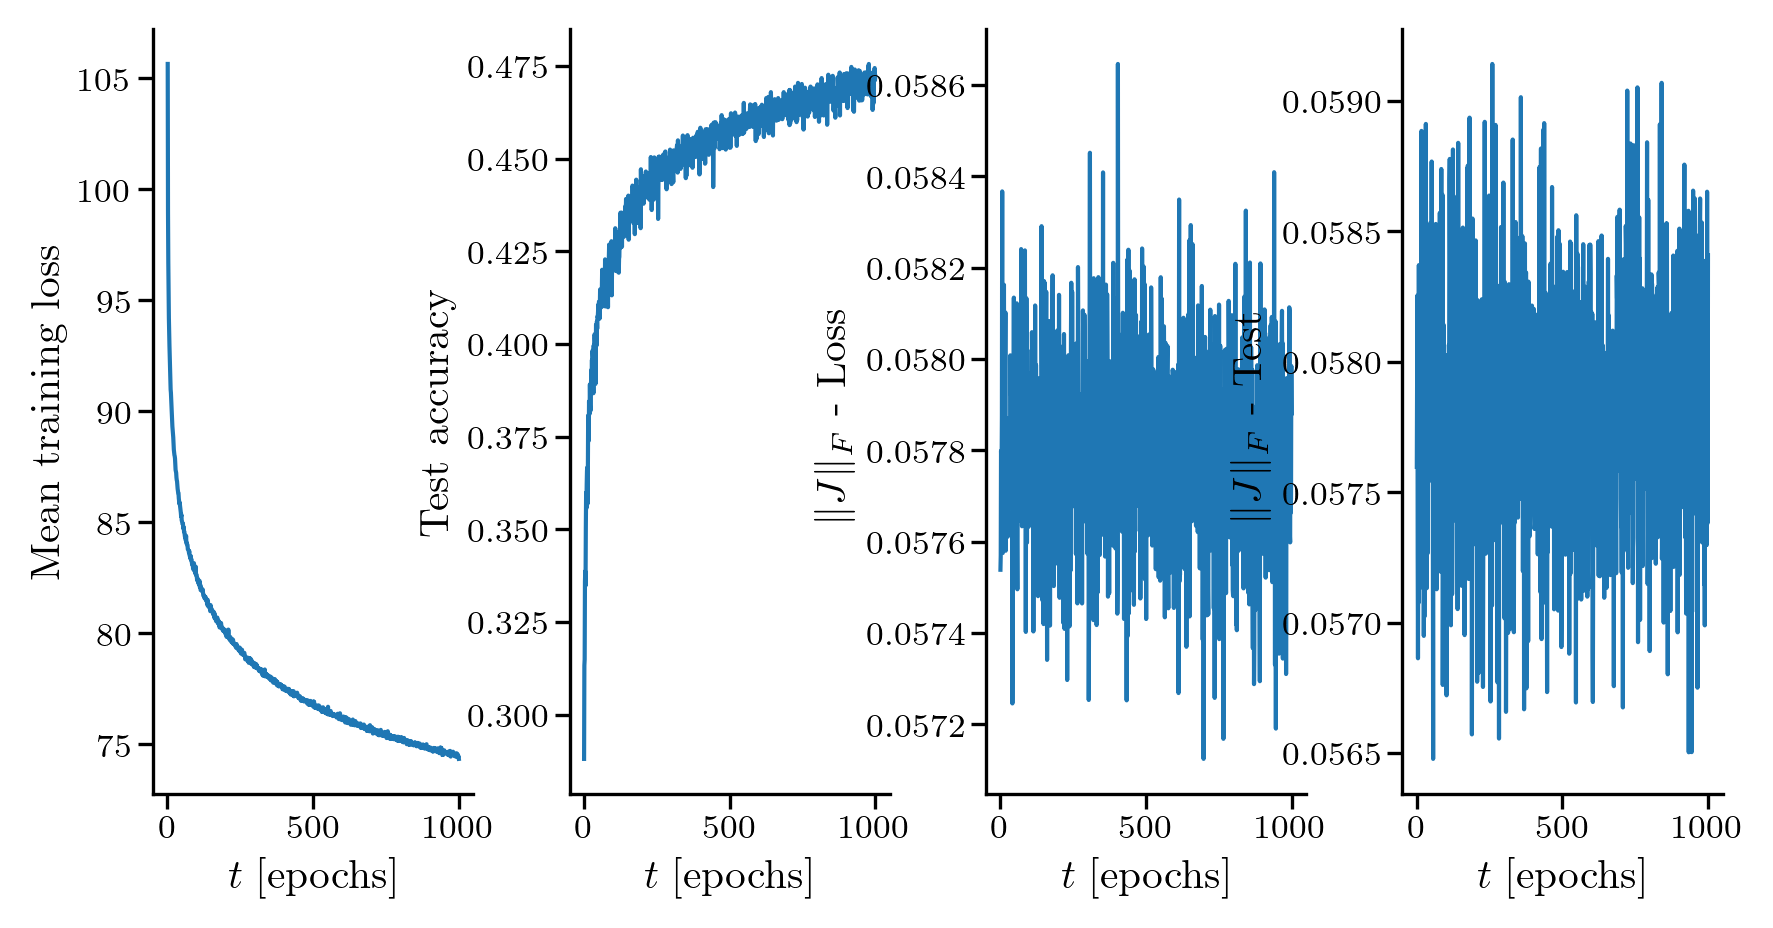

In [10]:
fig, axs = plt.subplots(1, 4)
axs[0].plot(log["epoch"], log["loss"])
axs[0].set_xlabel(r"$t \; [\textrm{epochs}]$")
axs[0].set_ylabel(r"Mean training loss")

axs[1].plot(log["epoch"], log["eval_acc"])
axs[1].set_xlabel(r"$t \; [\textrm{epochs}]$")
axs[1].set_ylabel(r"Test accuracy")

axs[2].plot(log["epoch"], np.array(log["JFReg_loss"]) / len(TrainLoader.dataset))
axs[2].set_xlabel(r"$t \; [\textrm{epochs}]$")
axs[2].set_ylabel(r"$\|J\|_{F}$ - Loss")

axs[3].plot(log["epoch"], np.array(log["eval_JFReg_score"]) / len(TestLoader.dataset))
axs[3].set_xlabel(r"$t \; [\textrm{epochs}]$")
axs[3].set_ylabel(r"$\|J\|_{F}$ - Test")

/tmp/ipykernel_2592444/478589364.py:3: RuntimeWarning: invalid value encountered in true_divide
  return a_ / a_.max()


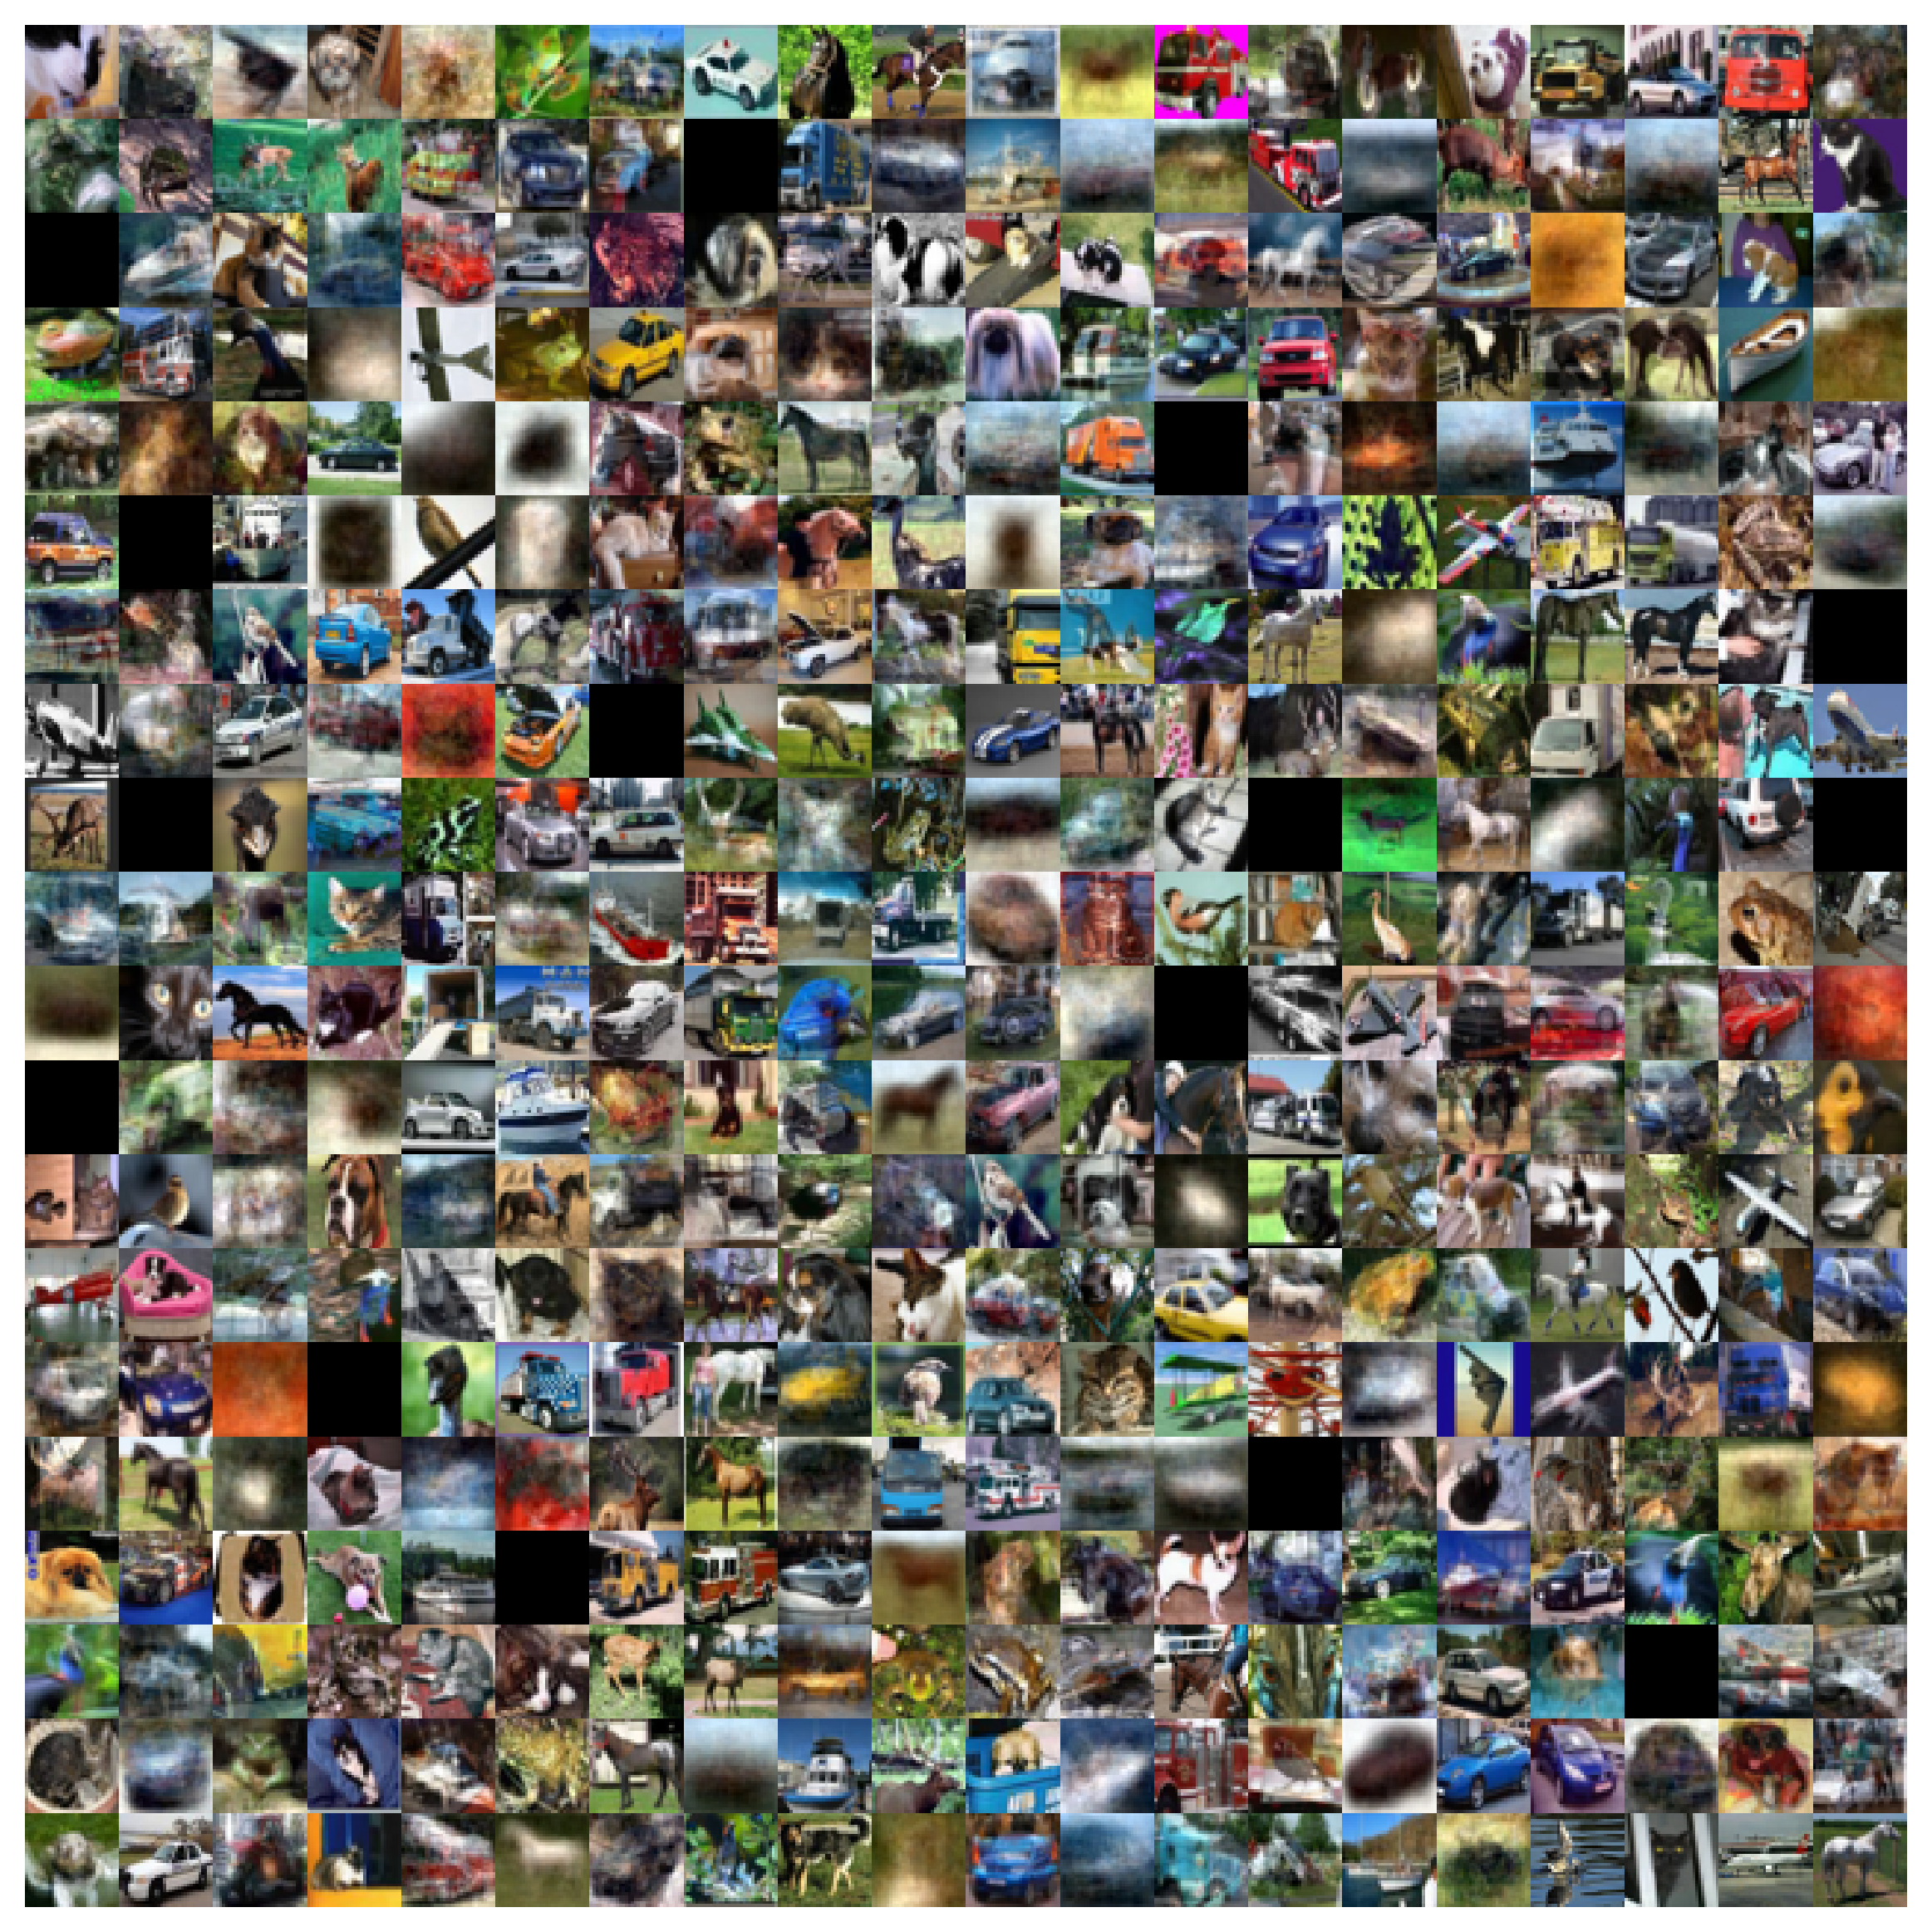

In [11]:
def minmaxnorm(a):
    a_ = a - a.min()
    return a_ / a_.max()

def draw_weights(synapses, n_hiddenx, n_hiddeny, n_pixelx=32, n_pixely=32, n_chan=3):
    cnt = 0
    synapses = synapses[np.random.choice(synapses.shape[0], n_hiddenx*n_hiddeny, replace=False)]
    HM = np.zeros((n_pixely*n_hiddeny, n_pixelx*n_hiddenx, n_chan))
    for y in range(n_hiddeny):
        for x in range(n_hiddenx):
            HM[y*n_pixely:(y+1)*n_pixely, x*n_pixelx:(x+1)*n_pixelx, :] = minmaxnorm(synapses[cnt].reshape(n_pixely, n_pixelx, n_chan))
            cnt += 1

    nc = np.max(np.absolute(HM))
    im = plt.imshow(HM, vmin=-nc, vmax=nc)
    plt.axis('off')
    
fig = plt.figure(figsize = (12.9, 10))
draw_weights(khmodel.local_learning.W.T.detach().cpu().numpy(), 20, 20)

# Single Hidden Layer Perceptron Model - No Regularization

In [5]:
# first initialize and save the model

In [9]:
shlp_pSet = khmodel.pSet.copy()
shlp_pSet["n"] = 1.0

In [13]:
# train the shlp model for comparison
shlp = SHLP(shlp_pSet)
shlp.to(device)
init_state = shlp.state_dict()
torch.save(init_state, model_path / shlp_init_name)

In [14]:
def shlp_schedule(epoch):
    if epoch <= 30:
        return 1e-3
    if (epoch <= 90) and (epoch > 30):
        return 5e-4
    if (epoch <= 120) and (epoch > 90):
        return 2e-4
    if (epoch <= 160) and (epoch > 120):
        return 1e-4
    return 1e-5

if False:
    shlp.train()
    ce_trainer = CETrainerJac(shlp, learning_rate=shlp_schedule)
    ce_trainer.run(TrainLoader, TestLoader, no_epochs=1000)
    ce_trainer.save(model_path / shlp_name, model_path / shlp_log_name)

In [15]:
shlp.state_dict()

OrderedDict([('W',
              tensor([[ 0.0408,  0.0119, -0.0139,  ...,  0.0023, -0.0093, -0.0109],
                      [ 0.0110, -0.0126,  0.0284,  ...,  0.0031, -0.0039, -0.0134],
                      [ 0.0227, -0.0118, -0.0404,  ...,  0.0151,  0.0047, -0.0047],
                      ...,
                      [-0.0299,  0.0170,  0.0307,  ..., -0.0204, -0.0146, -0.0011],
                      [ 0.0193, -0.0133, -0.0407,  ..., -0.0342, -0.0158, -0.0022],
                      [-0.0437, -0.0104,  0.0118,  ..., -0.0051,  0.0042,  0.0071]],
                     device='cuda:0')),
             ('dense.0.weight',
              tensor([[ 0.0014, -0.0104,  0.0197,  ..., -0.0149, -0.0076, -0.0109],
                      [-0.0019,  0.0076,  0.0171,  ...,  0.0124,  0.0086, -0.0045],
                      [-0.0136, -0.0032,  0.0149,  ..., -0.0077,  0.0175, -0.0161],
                      ...,
                      [-0.0083,  0.0078,  0.0033,  ..., -0.0076, -0.0019, -0.0089],
              

In [16]:
log_shlp = Trainers.Trainer.Logger()
log_shlp.load(model_path / shlp_log_name)

Text(0, 0.5, '$\\|J\\|_{F}$ - Test')

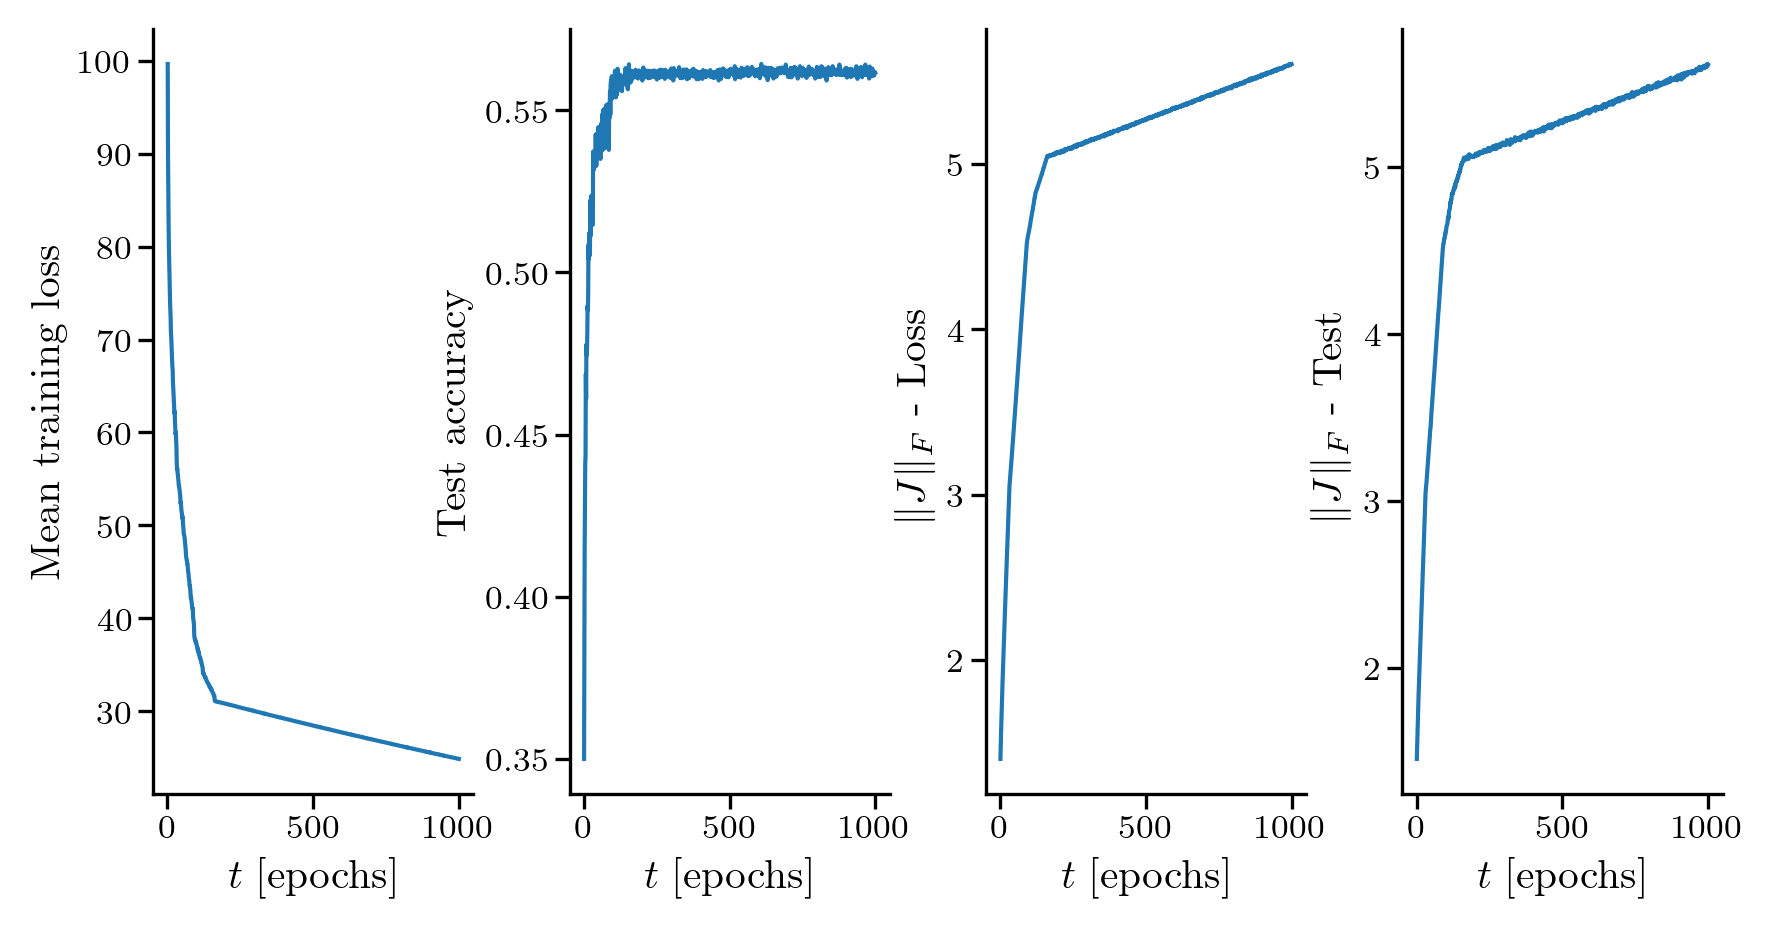

In [17]:
fig, axs = plt.subplots(1, 4)
axs[0].plot(log_shlp["epoch"], log_shlp["loss"])
axs[0].set_xlabel(r"$t \; [\textrm{epochs}]$")
axs[0].set_ylabel(r"Mean training loss")

axs[1].plot(log_shlp["epoch"], log_shlp["eval_acc"])
axs[1].set_xlabel(r"$t \; [\textrm{epochs}]$")
axs[1].set_ylabel(r"Test accuracy")

axs[2].plot(log_shlp["epoch"], np.array(log_shlp["JFReg_loss"]) / len(TrainLoader.dataset))
axs[2].set_xlabel(r"$t \; [\textrm{epochs}]$")
axs[2].set_ylabel(r"$\|J\|_{F}$ - Loss")

axs[3].plot(log_shlp["epoch"], np.array(log_shlp["eval_JFReg_score"]) / len(TestLoader.dataset))
axs[3].set_xlabel(r"$t \; [\textrm{epochs}]$")
axs[3].set_ylabel(r"$\|J\|_{F}$ - Test")

In [12]:
shlp_pSet = khmodel.pSet.copy()
shlp_pSet["n"] = 1.0
# train the shlp model for comparison
shlp = SHLP(shlp_pSet)
shlp.to(device)

In [19]:
def shlp_schedule(epoch):
    if epoch <= 30:
        return 1e-3
    if (epoch <= 90) and (epoch > 30):
        return 5e-4
    if (epoch <= 120) and (epoch > 90):
        return 2e-4
    if (epoch <= 160) and (epoch > 120):
        return 1e-4
    return 1e-5

if False:
    shlp.train()
    ce_trainer = CETrainerJac(shlp, learning_rate=shlp_schedule)
    ce_trainer.run(TrainLoader, TestLoader, no_epochs=1000)
    ce_trainer.save(model_path / shlp_name, model_path / shlp_log_name)

In [20]:
log_shlp = Trainers.Trainer.Logger()
log_shlp.load(model_path / shlp_log_name)

Text(0, 0.5, '$\\|J\\|_{F}$ - Test')

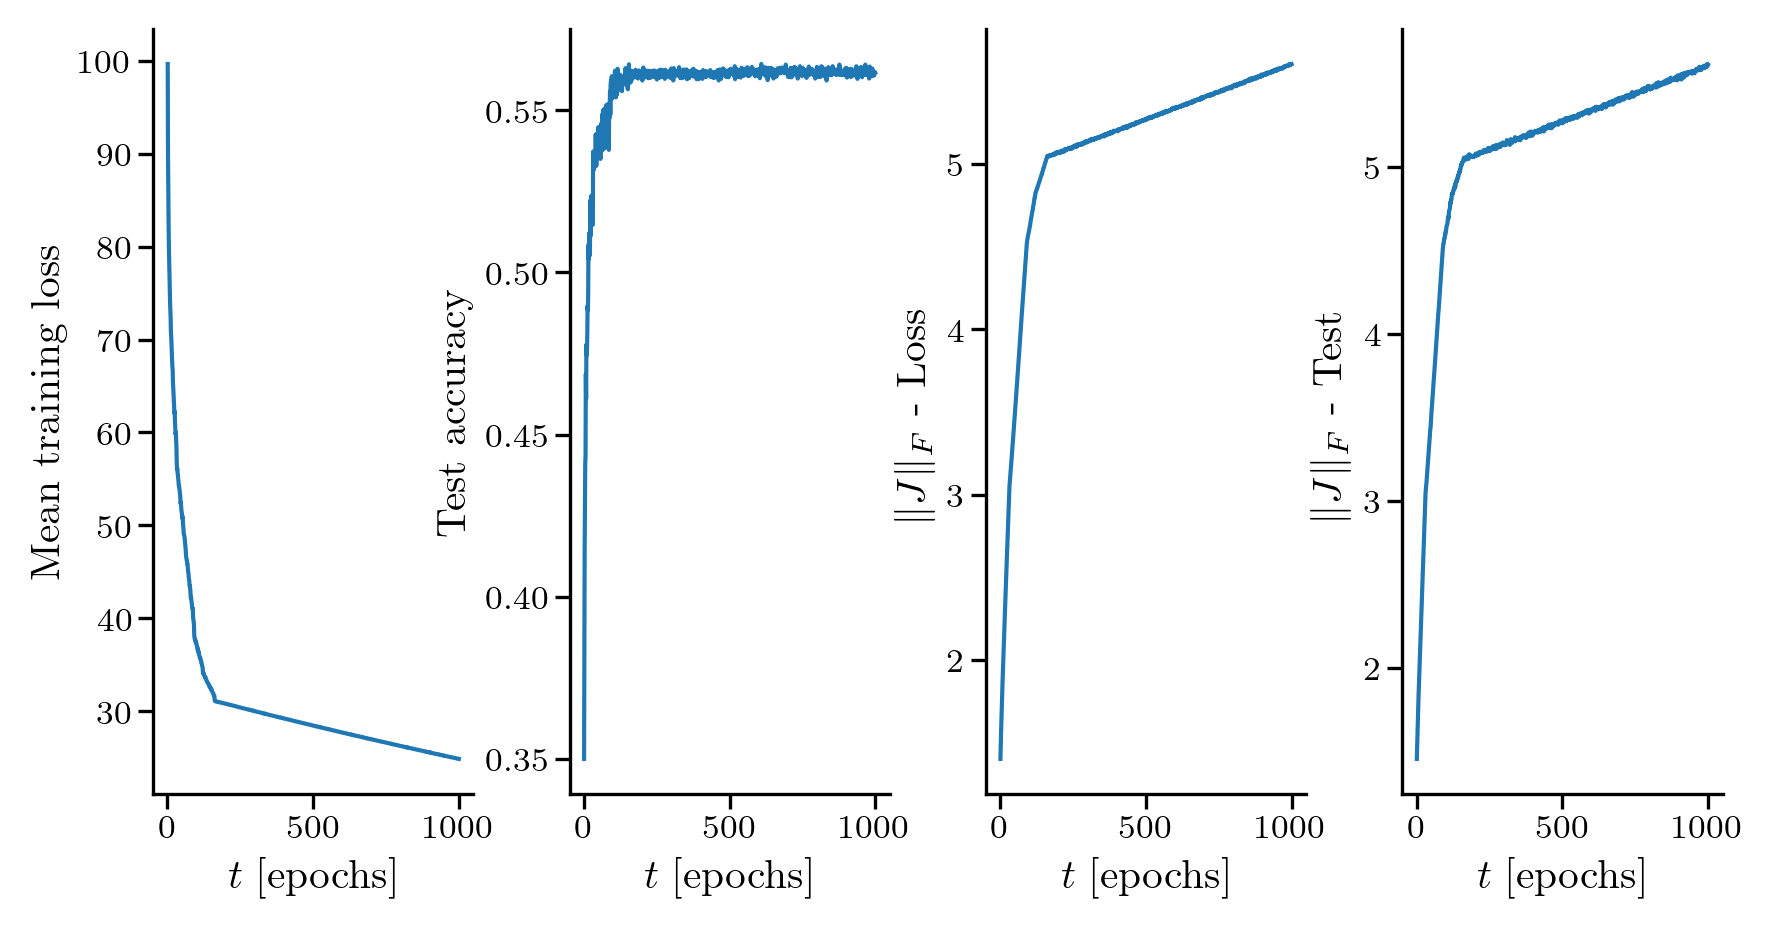

In [21]:
fig, axs = plt.subplots(1, 4)
axs[0].plot(log_shlp["epoch"], log_shlp["loss"])
axs[0].set_xlabel(r"$t \; [\textrm{epochs}]$")
axs[0].set_ylabel(r"Mean training loss")

axs[1].plot(log_shlp["epoch"], log_shlp["eval_acc"])
axs[1].set_xlabel(r"$t \; [\textrm{epochs}]$")
axs[1].set_ylabel(r"Test accuracy")

axs[2].plot(log_shlp["epoch"], np.array(log_shlp["JFReg_loss"]) / len(TrainLoader.dataset))
axs[2].set_xlabel(r"$t \; [\textrm{epochs}]$")
axs[2].set_ylabel(r"$\|J\|_{F}$ - Loss")

axs[3].plot(log_shlp["epoch"], np.array(log_shlp["eval_JFReg_score"]) / len(TestLoader.dataset))
axs[3].set_xlabel(r"$t \; [\textrm{epochs}]$")
axs[3].set_ylabel(r"$\|J\|_{F}$ - Test")

# L2-Regularization

In [22]:
shlp_pSet["n"] = 1.0
shlp_l2 = SHLP(shlp_pSet)
shlp_l2.to(device)

In [23]:
@LpReg(alpha_Lp=5e-4, p=2.0)
class LpTrainer(Trainers.CETrainer):
    pass

if False:
    shlp_l2.train()
    ce_trainer = LpTrainer(shlp_l2, learning_rate=shlp_schedule)
    ce_trainer.run(TrainLoader, TestLoader, no_epochs=1000)
    ce_trainer.save(model_path / shlp_l2_name, model_path / shlp_l2_log_name)

In [24]:
log_shlp_l2 = Trainers.Trainer.Logger()
log_shlp_l2.load(model_path / shlp_l2_log_name)

Text(0, 0.5, '$\\| \\cdot \\|_{L2}$ - Score')

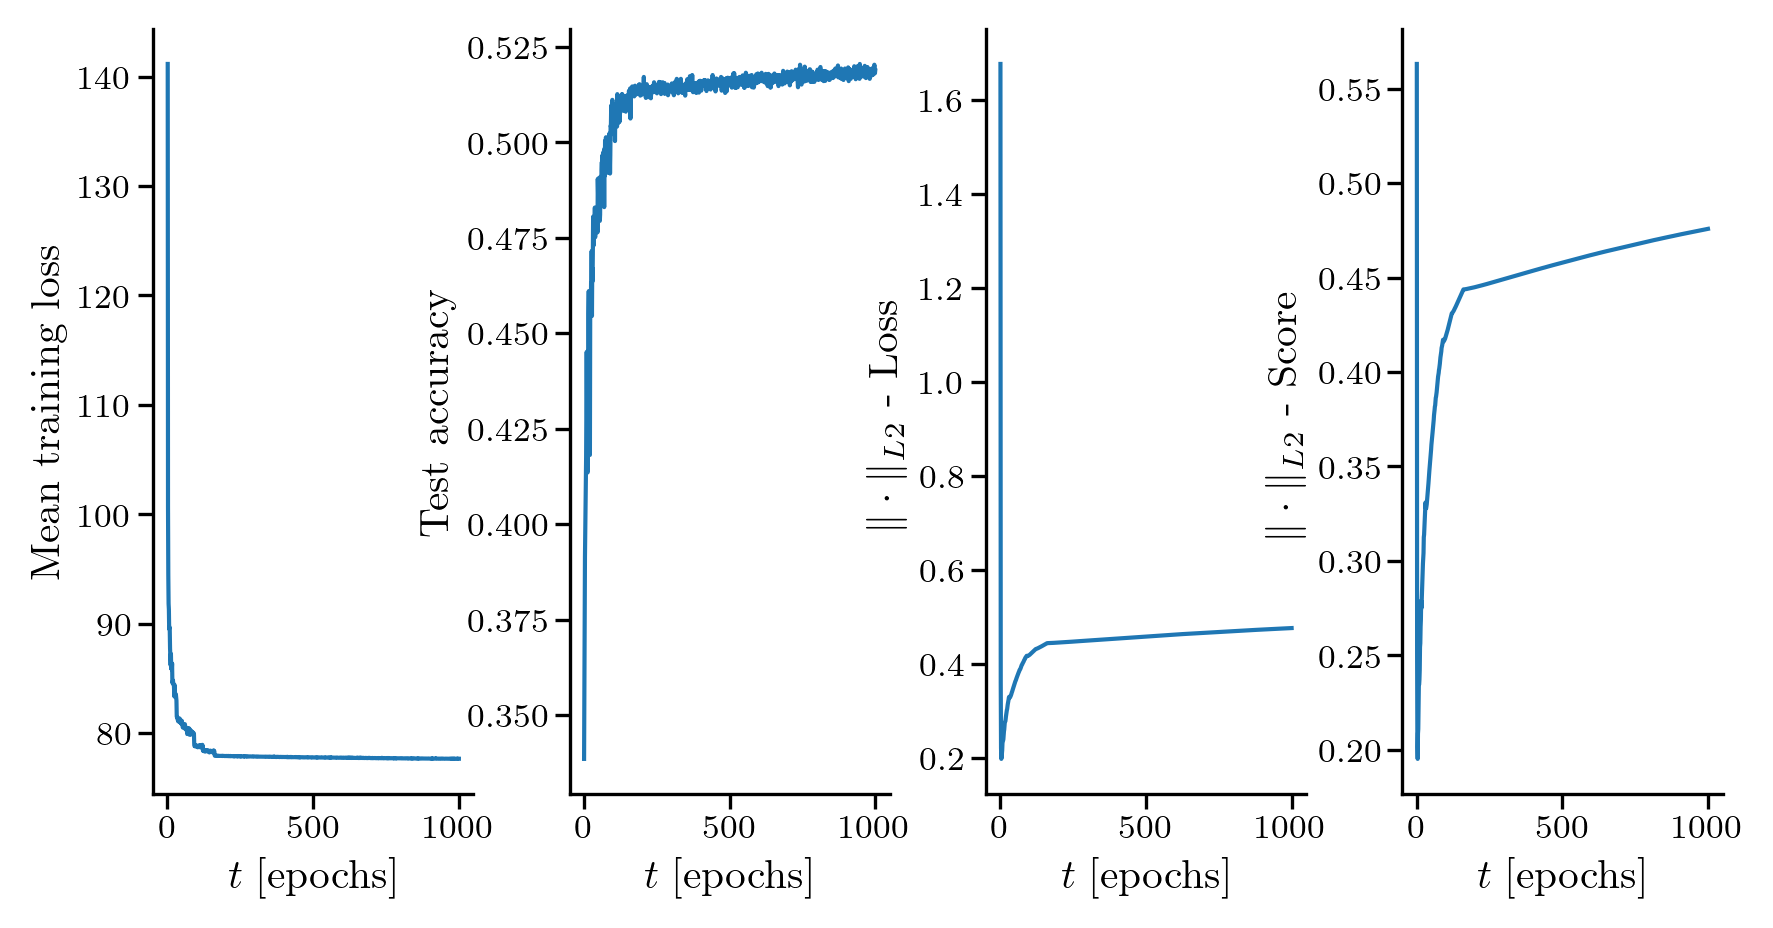

In [25]:
fig, axs = plt.subplots(1, 4)
axs[0].plot(log_shlp_l2["epoch"], log_shlp_l2["loss"])
axs[0].set_xlabel(r"$t \; [\textrm{epochs}]$")
axs[0].set_ylabel(r"Mean training loss")

axs[1].plot(log_shlp_l2["epoch"], log_shlp_l2["eval_acc"])
axs[1].set_xlabel(r"$t \; [\textrm{epochs}]$")
axs[1].set_ylabel(r"Test accuracy")

axs[2].plot(log_shlp_l2["epoch"], np.array(log_shlp_l2["LpReg_loss"]) / len(TrainLoader.dataset))
axs[2].set_xlabel(r"$t \; [\textrm{epochs}]$")
axs[2].set_ylabel(r"$\| \cdot \|_{L2}$ - Loss")

axs[3].plot(log_shlp_l2["epoch"], np.array(log_shlp_l2["eval_LpReg_score"]) / len(TestLoader.dataset))
axs[3].set_xlabel(r"$t \; [\textrm{epochs}]$")
axs[3].set_ylabel(r"$\| \cdot \|_{L2}$ - Score")

# Jacobian Regularized Model

In [26]:
shlp_jreg = SHLP(shlp_pSet)
shlp_jreg.to(device)

In [27]:
@JFReg(alpha_JF=1e-3, n=3)
class JFRegTrainer(Trainers.CETrainer):
    pass

In [28]:
if False:
    shlp_jreg.train()
    trainer = JFRegTrainer(shlp_jreg, learning_rate=shlp_schedule)
    trainer.run(TrainLoader, TestLoader, no_epochs=1000)
    trainer.save(model_path / shlp_jreg_name, model_path / shlp_jreg_log_name)

In [29]:
log_shlp_jreg = Trainers.Trainer.Logger()
log_shlp_jreg.load(model_path / shlp_jreg_log_name)

Text(0, 0.5, '$\\|J\\|_{F}$ - Test')

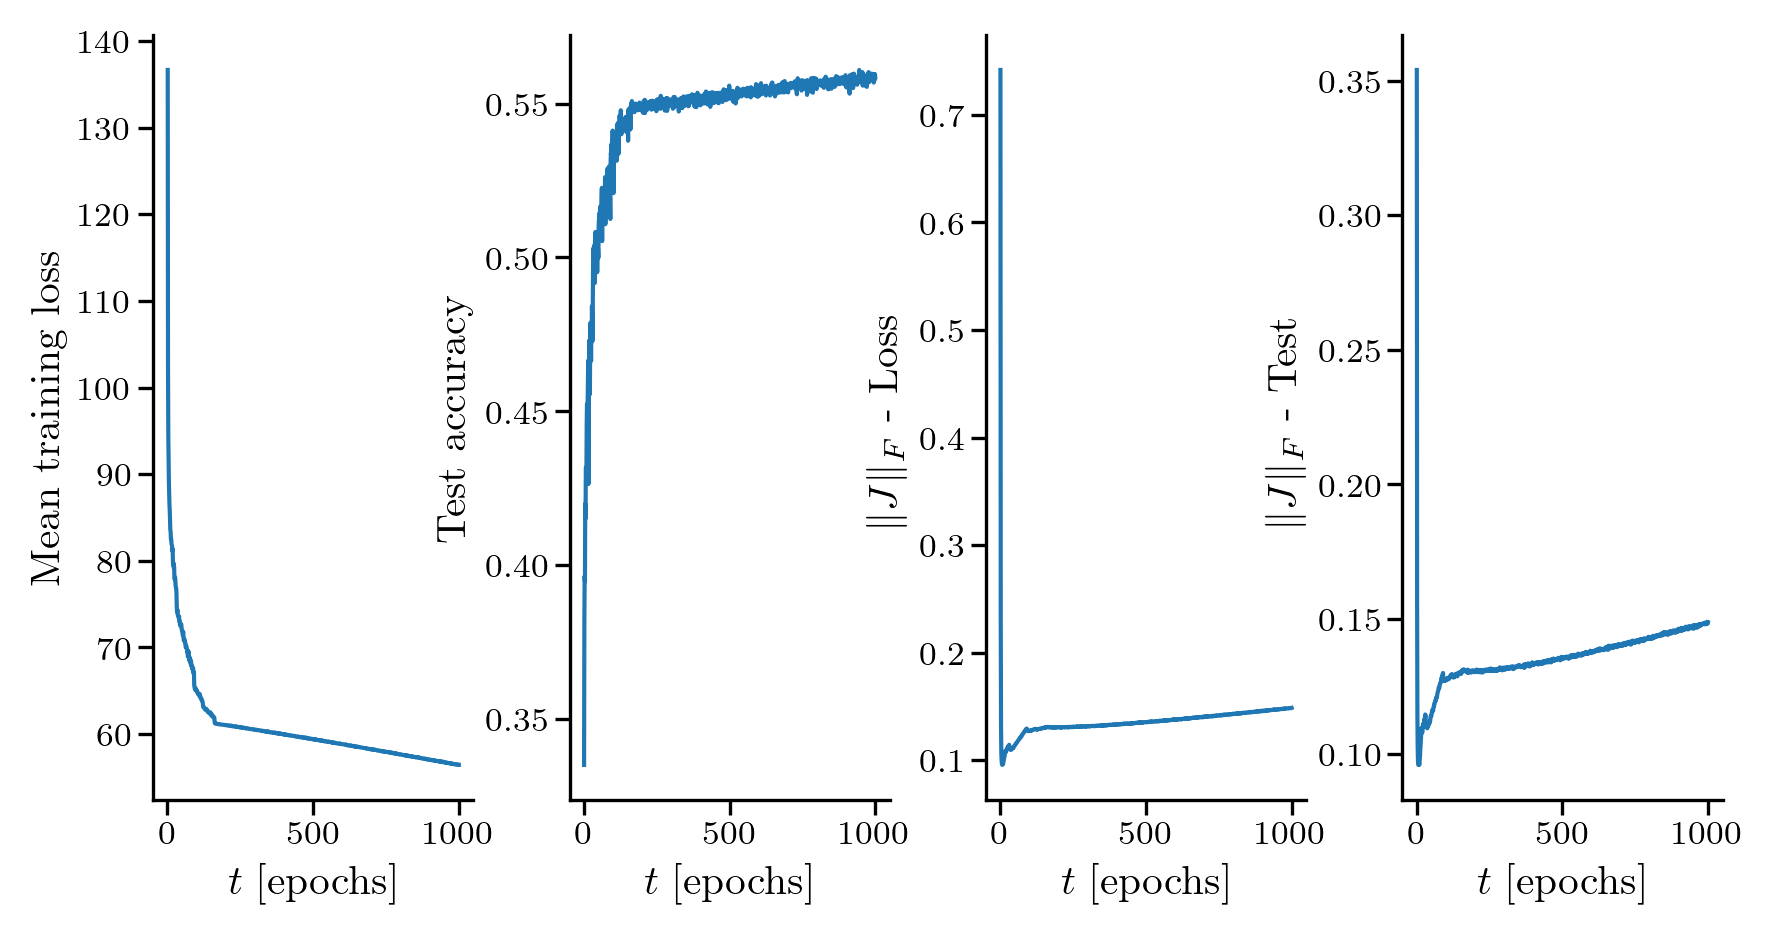

In [30]:
fig, axs = plt.subplots(1, 4)
axs[0].plot(log_shlp["epoch"], log_shlp_jreg["loss"])
axs[0].set_xlabel(r"$t \; [\textrm{epochs}]$")
axs[0].set_ylabel(r"Mean training loss")

axs[1].plot(log_shlp["epoch"], log_shlp_jreg["eval_acc"])
axs[1].set_xlabel(r"$t \; [\textrm{epochs}]$")
axs[1].set_ylabel(r"Test accuracy")

axs[2].plot(log_shlp["epoch"], np.array(log_shlp_jreg["JFReg_loss"]) / len(TrainLoader.dataset))
axs[2].set_xlabel(r"$t \; [\textrm{epochs}]$")
axs[2].set_ylabel(r"$\|J\|_{F}$ - Loss")

axs[3].plot(log_shlp["epoch"], np.array(log_shlp_jreg["eval_JFReg_score"]) / len(TestLoader.dataset))
axs[3].set_xlabel(r"$t \; [\textrm{epochs}]$")
axs[3].set_ylabel(r"$\|J\|_{F}$ - Test")

# Spectral Regularized Model

In [13]:
shlp_specreg = SHLP(shlp_pSet, batch_norm=True)
shlp_specreg.to(device)

In [15]:
@SpecReg(alpha_SR=1.0, alpha=1.0, tau=0)
@JFReg(alpha_JF=0.0, n=3)
class SpecRegTrainer(Trainers.CETrainer):
    pass

In [16]:
gamma = 30.0

def specreg_schedule(epoch):
    if epoch <= 90:
        return 1e-3
    if epoch >= 90:
        return 1e-3*np.exp(- (epoch - 90) / gamma )
    #if (epoch <= 200) and (epoch > 100):
    #    return 5e-4
    #if (epoch <= 400) and (epoch > 100):
    #    return 1e-5
    #    return 2e-4
    #if (epoch <= 160) and (epoch > 120):
    #    return 1e-4
    #return 5e-6

In [17]:
if False:
    shlp_specreg.train()
    trainer = SpecRegTrainer(shlp_specreg, learning_rate=specreg_schedule)
    trainer.run(TrainLoader, TestLoader, no_epochs=NUMBER_OF_EPOCHS)
    trainer.save(model_path / shlp_specreg_name, model_path / shlp_specreg_log_name)

In [18]:
log_shlp_specreg = Trainers.Trainer.Logger()
log_shlp_specreg.load(model_path / shlp_specreg_log_name)

In [19]:
log_shlp_specreg.keys()

dict_keys(['epoch', 'loss', 'ce_loss', 'eval_acc', 'JFReg_loss', 'eval_JFReg_score', 'SpecReg_loss', 'eval_SpecReg_score'])

In [20]:
l_n = cov_spectrum(TestLoader, shlp_specreg)

  0%|          | 0/10 [00:00<?, ?batch/s]

Text(0, 0.5, '$\\lambda_{n}$')

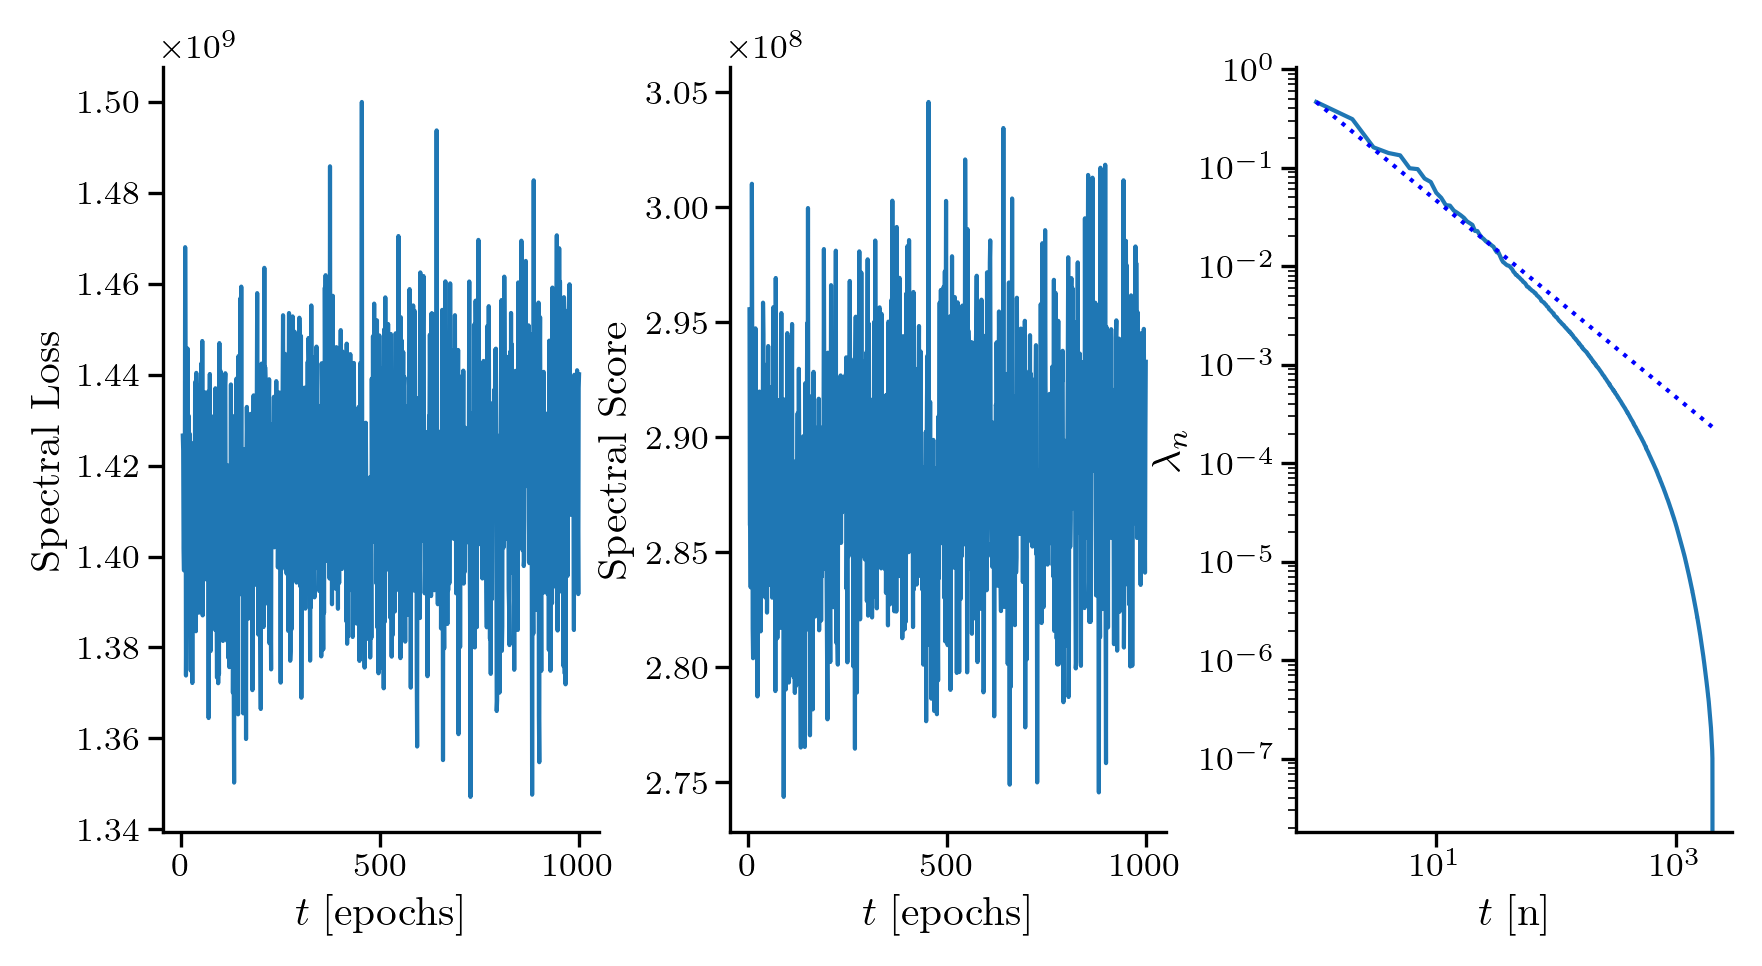

In [21]:
fig, axs = plt.subplots(1, 3)
axs[0].plot(log_shlp_specreg["epoch"][3:], np.array(log_shlp_specreg["SpecReg_loss"])[3:])
axs[0].set_xlabel(r"$t \; [\textrm{epochs}]$")
axs[0].set_ylabel(r"Spectral Loss")

axs[1].plot(log_shlp_specreg["epoch"][3:], np.array(log_shlp_specreg["eval_SpecReg_score"])[3:])
axs[1].set_xlabel(r"$t \; [\textrm{epochs}]$")
axs[1].set_ylabel(r"Spectral Score")

n = np.arange(1, len(l_n)+1)
l_n_np = l_n.detach().cpu().numpy()
stringer_n = l_n_np[0] / n

axs[2].loglog(n, l_n_np)
axs[2].loglog(n, stringer_n, ":b")
axs[2].set_xlabel(r"$t \; [\textrm{n}]$")
axs[2].set_ylabel(r"$\lambda_{n}$")

Text(0, 0.5, '$\\|J\\|_{F}$ - Test')

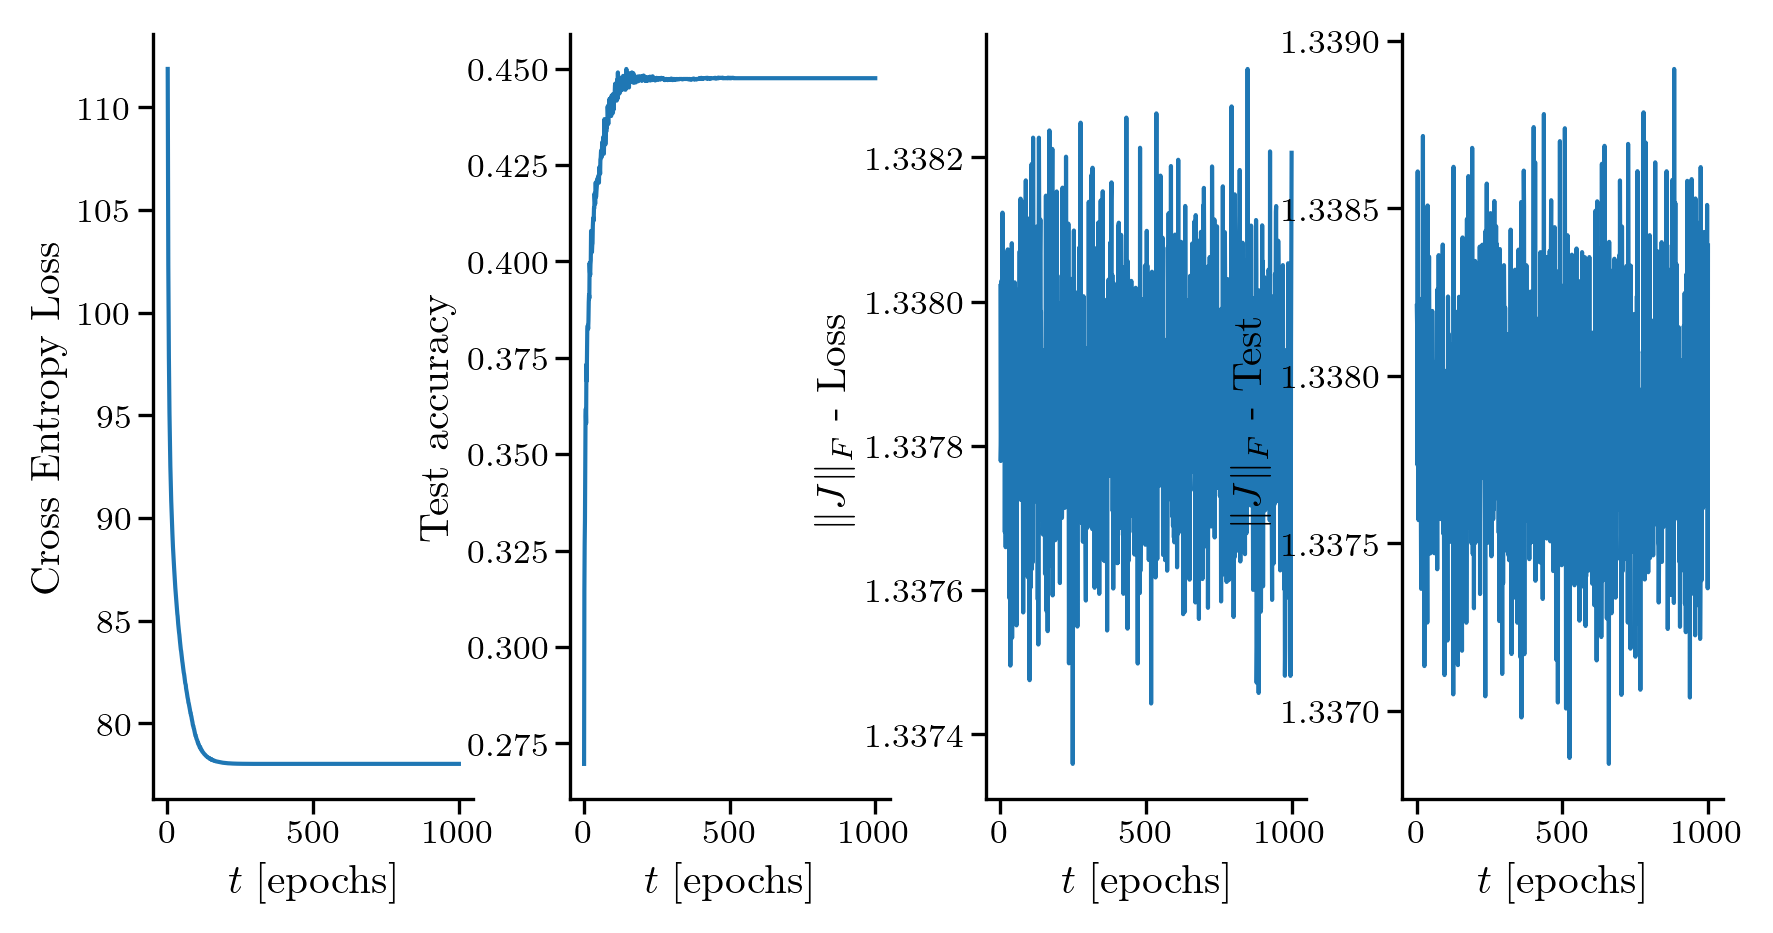

In [39]:
fig, axs = plt.subplots(1, 4)
axs[0].plot(log_shlp_specreg["epoch"], log_shlp_specreg["ce_loss"])
axs[0].set_xlabel(r"$t \; [\textrm{epochs}]$")
axs[0].set_ylabel(r"Cross Entropy Loss")

axs[1].plot(log_shlp_specreg["epoch"], log_shlp_specreg["eval_acc"])
axs[1].set_xlabel(r"$t \; [\textrm{epochs}]$")
axs[1].set_ylabel(r"Test accuracy")

axs[2].plot(log_shlp_specreg["epoch"], np.array(log_shlp_specreg["JFReg_loss"]) / len(TrainLoader.dataset))
axs[2].set_xlabel(r"$t \; [\textrm{epochs}]$")
axs[2].set_ylabel(r"$\|J\|_{F}$ - Loss")

axs[3].plot(log_shlp_specreg["epoch"], np.array(log_shlp_specreg["eval_JFReg_score"]) / len(TestLoader.dataset))
axs[3].set_xlabel(r"$t \; [\textrm{epochs}]$")
axs[3].set_ylabel(r"$\|J\|_{F}$ - Test")

# Adjusted Exponent

In [51]:
shlp_specreg_kh = SHLP(shlp_pSet, batch_norm=True)
shlp_specreg_kh.to(device)

In [52]:
gamma = 80.0
alpha_lambda = 2.62

def specreg_schedule_adj(epoch):
    if epoch <= 200:
        return 1e-3
    if epoch >= 200:
        return 1e-3*np.exp(- (epoch - 200) / gamma )

In [53]:
@SpecReg(alpha_SR=1e-3, alpha=alpha_lambda, tau=10)
@JFReg(alpha_JF=0.0, n=3)
class SpecRegKHTrainer(Trainers.CETrainer):
    pass

In [54]:
if TRAIN:
    shlp_specreg_kh.train()
    trainer = SpecRegKHTrainer(shlp_specreg_kh, learning_rate=1e-3)
    trainer.run(TrainLoader, TestLoader, no_epochs=1000)
    trainer.save(model_path / shlp_specreg_kh_name, model_path / shlp_specreg_kh_log_name)

  0%|          | 0/1000 [00:00<?, ?epoch/s]

In [55]:
log_shlp_specreg_kh = Trainers.Trainer.Logger()
log_shlp_specreg_kh.load(model_path / shlp_specreg_kh_log_name)

In [56]:
l_n = cov_spectrum(TestLoader, shlp_specreg_kh)

  0%|          | 0/10 [00:00<?, ?batch/s]

Text(0, 0.5, '$\\lambda_{n}$')

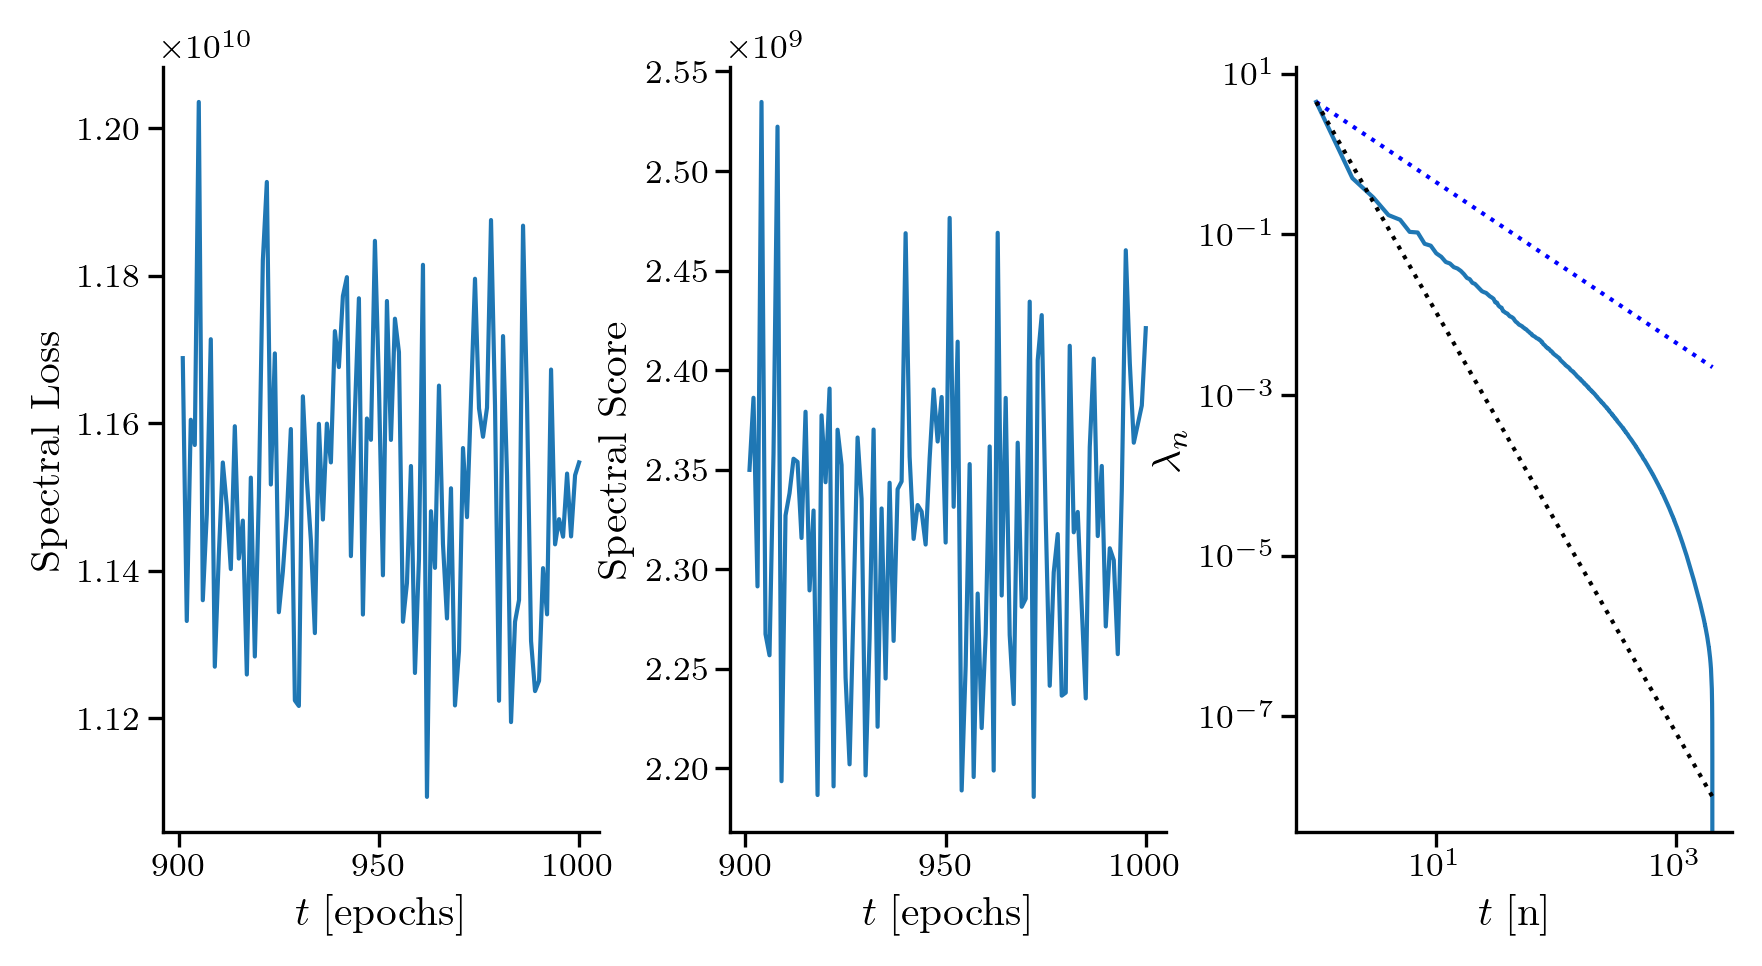

In [57]:
fig, axs = plt.subplots(1, 3)
axs[0].plot(log_shlp_specreg_kh["epoch"][900:], np.array(log_shlp_specreg_kh["SpecReg_loss"])[900:])
axs[0].set_xlabel(r"$t \; [\textrm{epochs}]$")
axs[0].set_ylabel(r"Spectral Loss")

axs[1].plot(log_shlp_specreg_kh["epoch"][900:], np.array(log_shlp_specreg_kh["eval_SpecReg_score"])[900:])
axs[1].set_xlabel(r"$t \; [\textrm{epochs}]$")
axs[1].set_ylabel(r"Spectral Score")

l_n_np = l_n.detach().cpu().numpy()
n = np.arange(1, len(l_n)+1)
stringer_n = l_n_np[0] / n
kh_n = l_n_np[0] / (n**alpha_lambda)#2.62

axs[2].loglog(n, l_n.detach().cpu().numpy())
axs[2].loglog(n, stringer_n, ":b")
axs[2].loglog(n, kh_n, ":k")
axs[2].set_xlabel(r"$t \; [\textrm{n}]$")
axs[2].set_ylabel(r"$\lambda_{n}$")

Text(0, 0.5, '$\\|J\\|_{F}$ - Test')

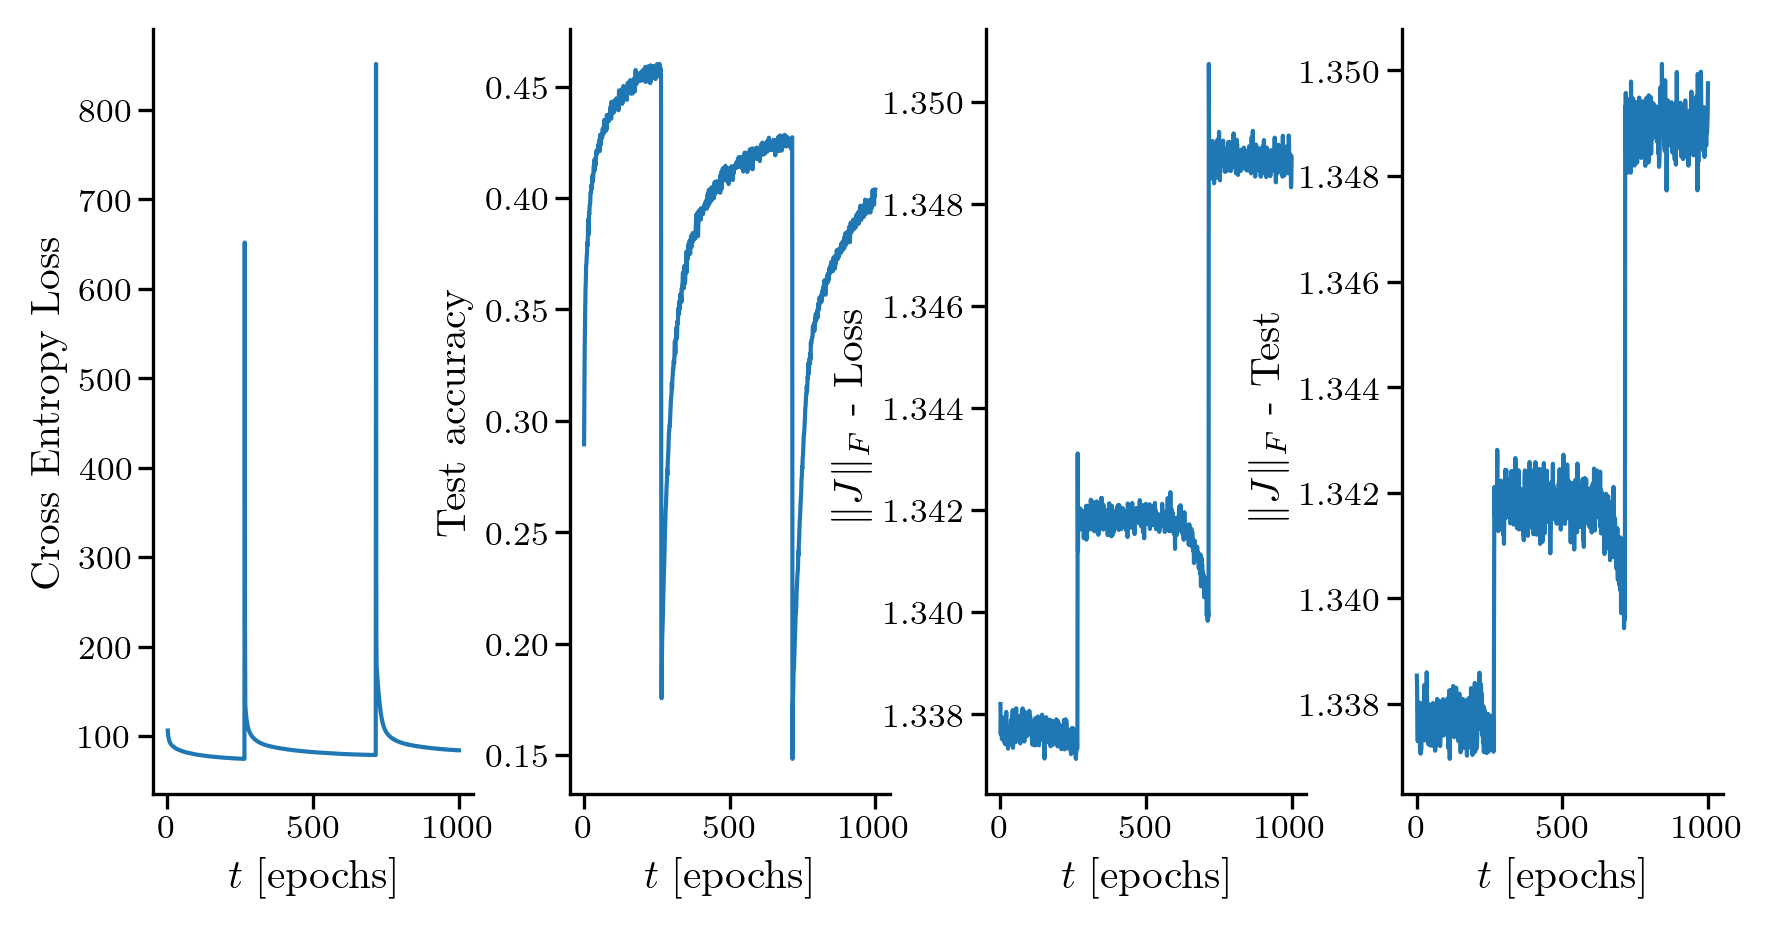

In [58]:
fig, axs = plt.subplots(1, 4)
axs[0].plot(log_shlp_specreg_kh["epoch"][1:], log_shlp_specreg_kh["ce_loss"][1:])
axs[0].set_xlabel(r"$t \; [\textrm{epochs}]$")
axs[0].set_ylabel(r"Cross Entropy Loss")

axs[1].plot(log_shlp_specreg_kh["epoch"], log_shlp_specreg_kh["eval_acc"])
axs[1].set_xlabel(r"$t \; [\textrm{epochs}]$")
axs[1].set_ylabel(r"Test accuracy")

axs[2].plot(log_shlp_specreg_kh["epoch"], np.array(log_shlp_specreg_kh["JFReg_loss"]) / len(TrainLoader.dataset))
axs[2].set_xlabel(r"$t \; [\textrm{epochs}]$")
axs[2].set_ylabel(r"$\|J\|_{F}$ - Loss")

axs[3].plot(log_shlp_specreg_kh["epoch"], np.array(log_shlp_specreg_kh["eval_JFReg_score"]) / len(TestLoader.dataset))
axs[3].set_xlabel(r"$t \; [\textrm{epochs}]$")
axs[3].set_ylabel(r"$\|J\|_{F}$ - Test")